In [1]:
import io, requests, glob, os, math
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [3]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

with sqlite3.connect("covid.db") as conn:
    data.to_sql(name='DataRaw', con=conn, if_exists='replace', index=False)
    data = pd.read_sql("""
WITH Analyzed AS (
SELECT
    date(Datum, '-1 day') AS Datum,
    BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung,
    BestaetigteFaelleBundeslaender - LAG(BestaetigteFaelleBundeslaender, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS Neuinfektionen,
    TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS TestungenPCR,
    Hospitalisierung - LAG(Hospitalisierung, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS HospitalisierungDiff
FROM DataRaw)
SELECT 
    Datum, BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung, HospitalisierungDiff,
    CASE WHEN Neuinfektionen >= 0 THEN Neuinfektionen ELSE NULL END AS Neuinfektionen,
    CASE WHEN TestungenPCR >= 0 THEN TestungenPCR ELSE NULL END AS TestungenPCR,    
    AVG(Neuinfektionen) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Neuinfektionen7DayAvg,
    AVG(Hospitalisierung) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Hospitalisierung7DayAvg,
    AVG(TestungenPCR) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS TestungenPCR7DayAvg
FROM Analyzed;
    """, conn)
    for bl in data["Name"].unique():
        for param in ["TestungenPCR", "HospitalisierungDiff", "Hospitalisierung", "Neuinfektionen"]:
            data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")
        # Fill na values for first diff.
        data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.to_sql(name='DataAnalyzed', con=conn, if_exists='replace', index=False)
    conn.execute("VACUUM")


In [4]:
with sqlite3.connect("covid.db") as conn:
    data = pd.read_sql("SELECT * FROM DataAnalyzed ORDER BY Datum, BundeslandId", conn)
    data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)

## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [5]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-26,769,2 318,6 147,5 967,2 679,4 802,4 069,1 591,14 711,43 053
2022-01-27,1 160,2 091,5 649,6 704,2 572,5 874,3 159,1 823,9 599,38 631
2022-01-28,946,2 467,5 552,5 946,2 425,4 350,3 116,2 083,7 863,34 748
2022-01-29,648,1 837,4 913,4 455,1 833,3 946,1 574,1 654,6 267,27 127
2022-01-30,689,1 642,4 407,5 266,1 549,3 127,2 809,1 120,6 802,27 411
2022-01-31,662,1 305,4 588,4 020,1 493,3 030,3 855,1 524,5 417,25 894
2022-02-01,917,1 374,6 200,6 814,3 050,6 524,2 260,1 820,10 451,39 410


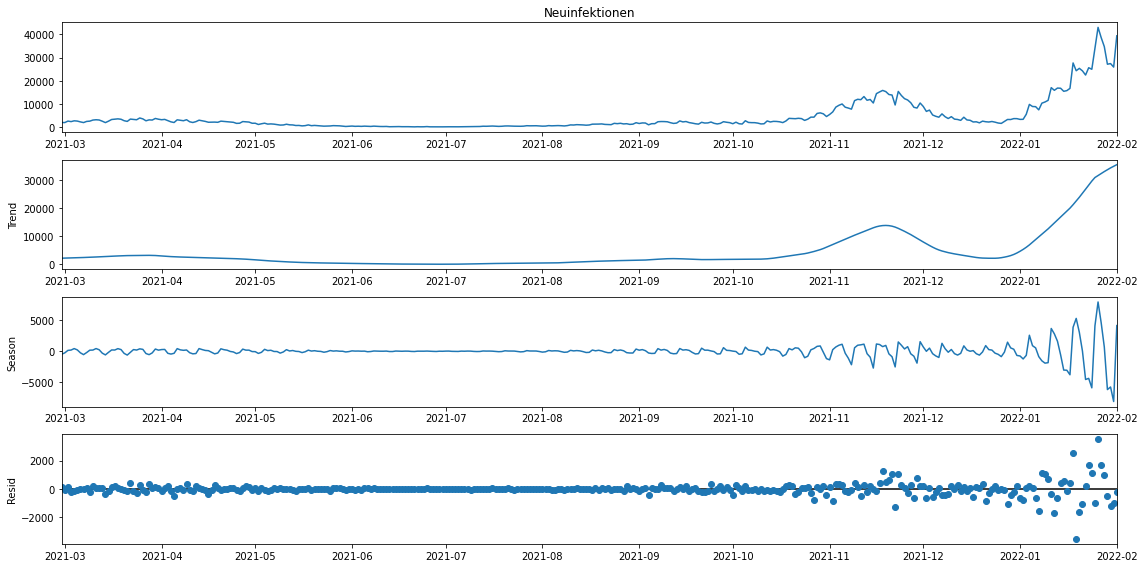

In [6]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [7]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,Neuinfektionen
2022-02-02,50 677
2022-02-03,46 098
2022-02-04,42 039
2022-02-05,34 205
2022-02-06,34 253
2022-02-07,32 468
2022-02-08,45 789


## Hospitalisierung
### Werte der letzten 7 Tage

In [8]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(7*10)["HospitalisierungDiff"],
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-26,53 (1),122 (1),191 (8),153 (-3),90 (-2),145 (4),143 (-3),57 (1),361 (-8),1 315 (-1)
2022-01-27,47 (-6),115 (-7),201 (10),164 (11),86 (-4),144 (-1),144 (1),61 (4),433 (72),1 395 (80)
2022-01-28,47 (0),109 (-6),208 (7),159 (-5),91 (5),145 (1),135 (-9),59 (-2),449 (16),1 402 (7)
2022-01-29,51 (4),114 (5),214 (6),181 (22),88 (-3),145 (0),132 (-3),64 (5),459 (10),1 448 (46)
2022-01-30,52 (1),123 (9),221 (7),192 (11),84 (-4),156 (11),130 (-2),76 (12),472 (13),1 506 (58)
2022-01-31,64 (12),139 (16),256 (35),220 (28),82 (-2),177 (21),143 (13),72 (-4),495 (23),1 648 (142)
2022-02-01,67 (3),141 (2),252 (-4),227 (7),84 (2),202 (25),143 (0),67 (-5),514 (19),1 697 (49)


### Diagramm

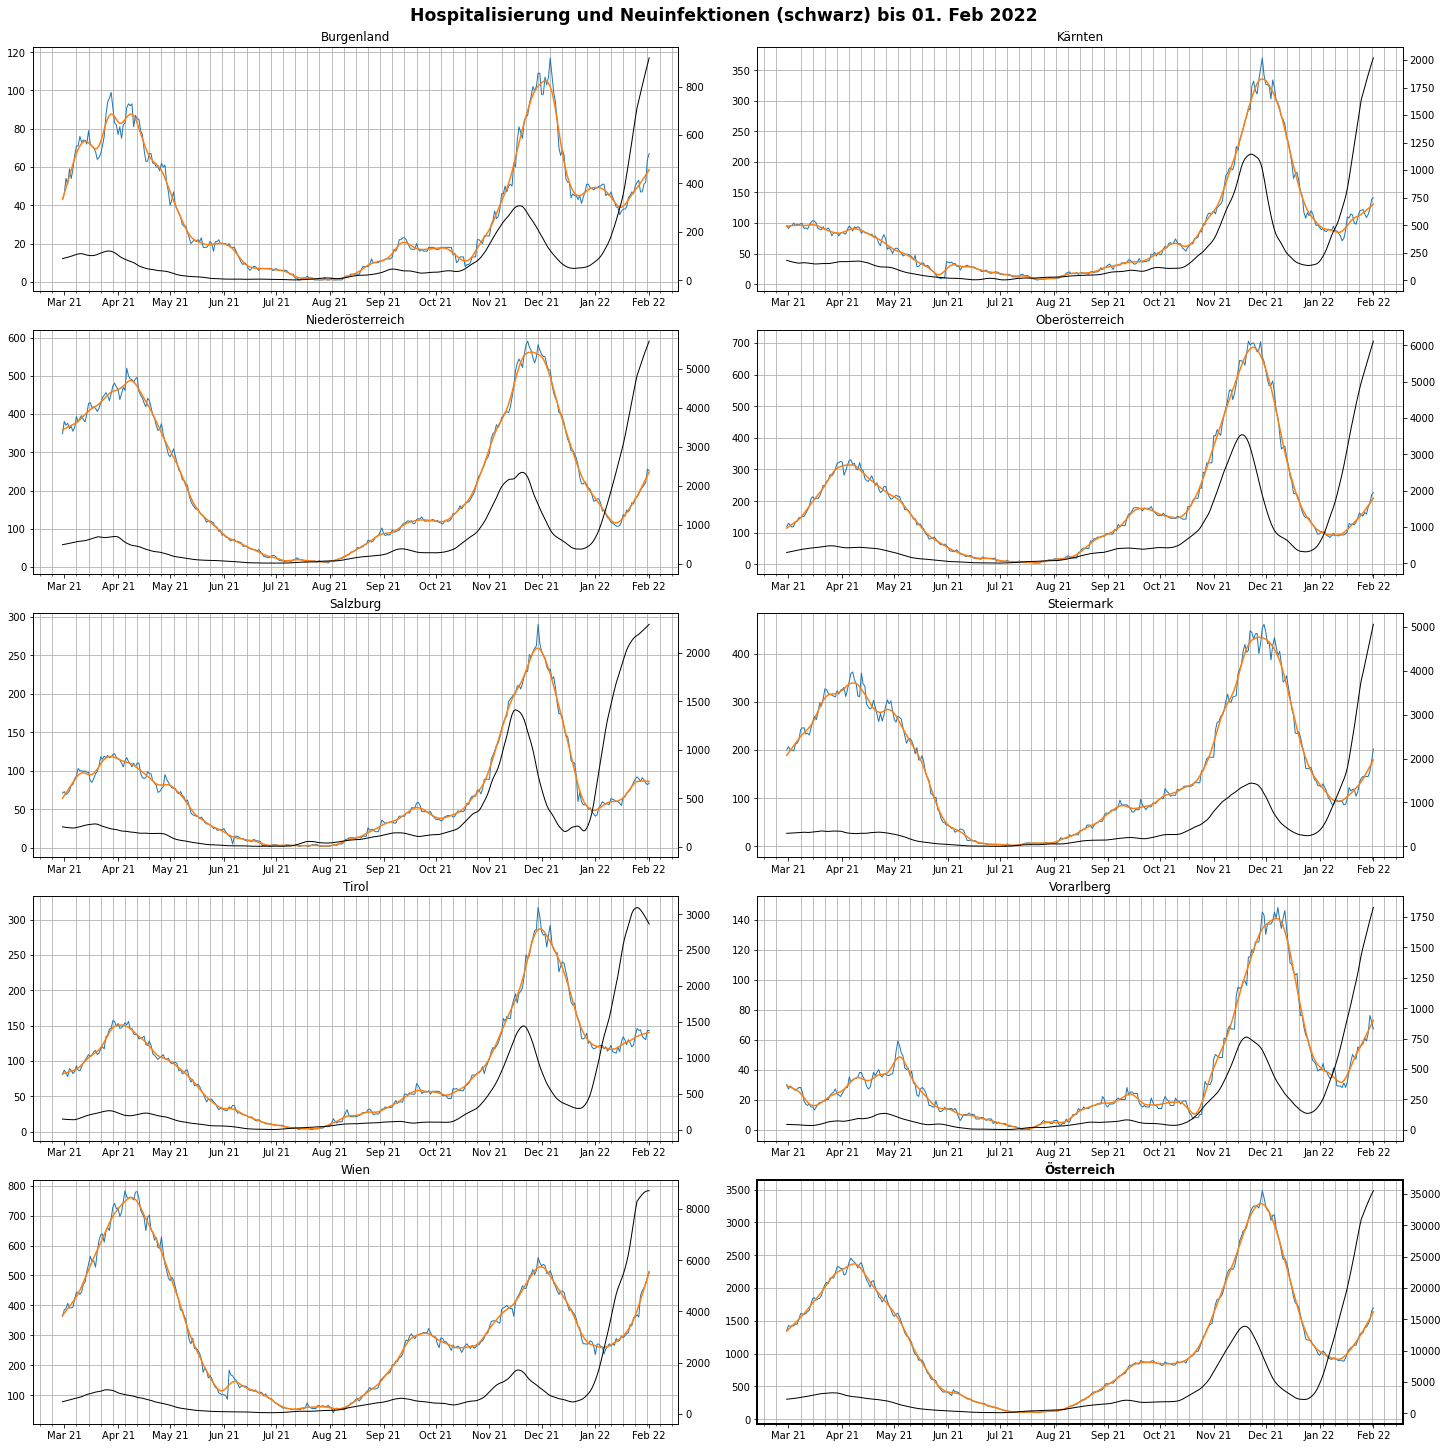

In [9]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

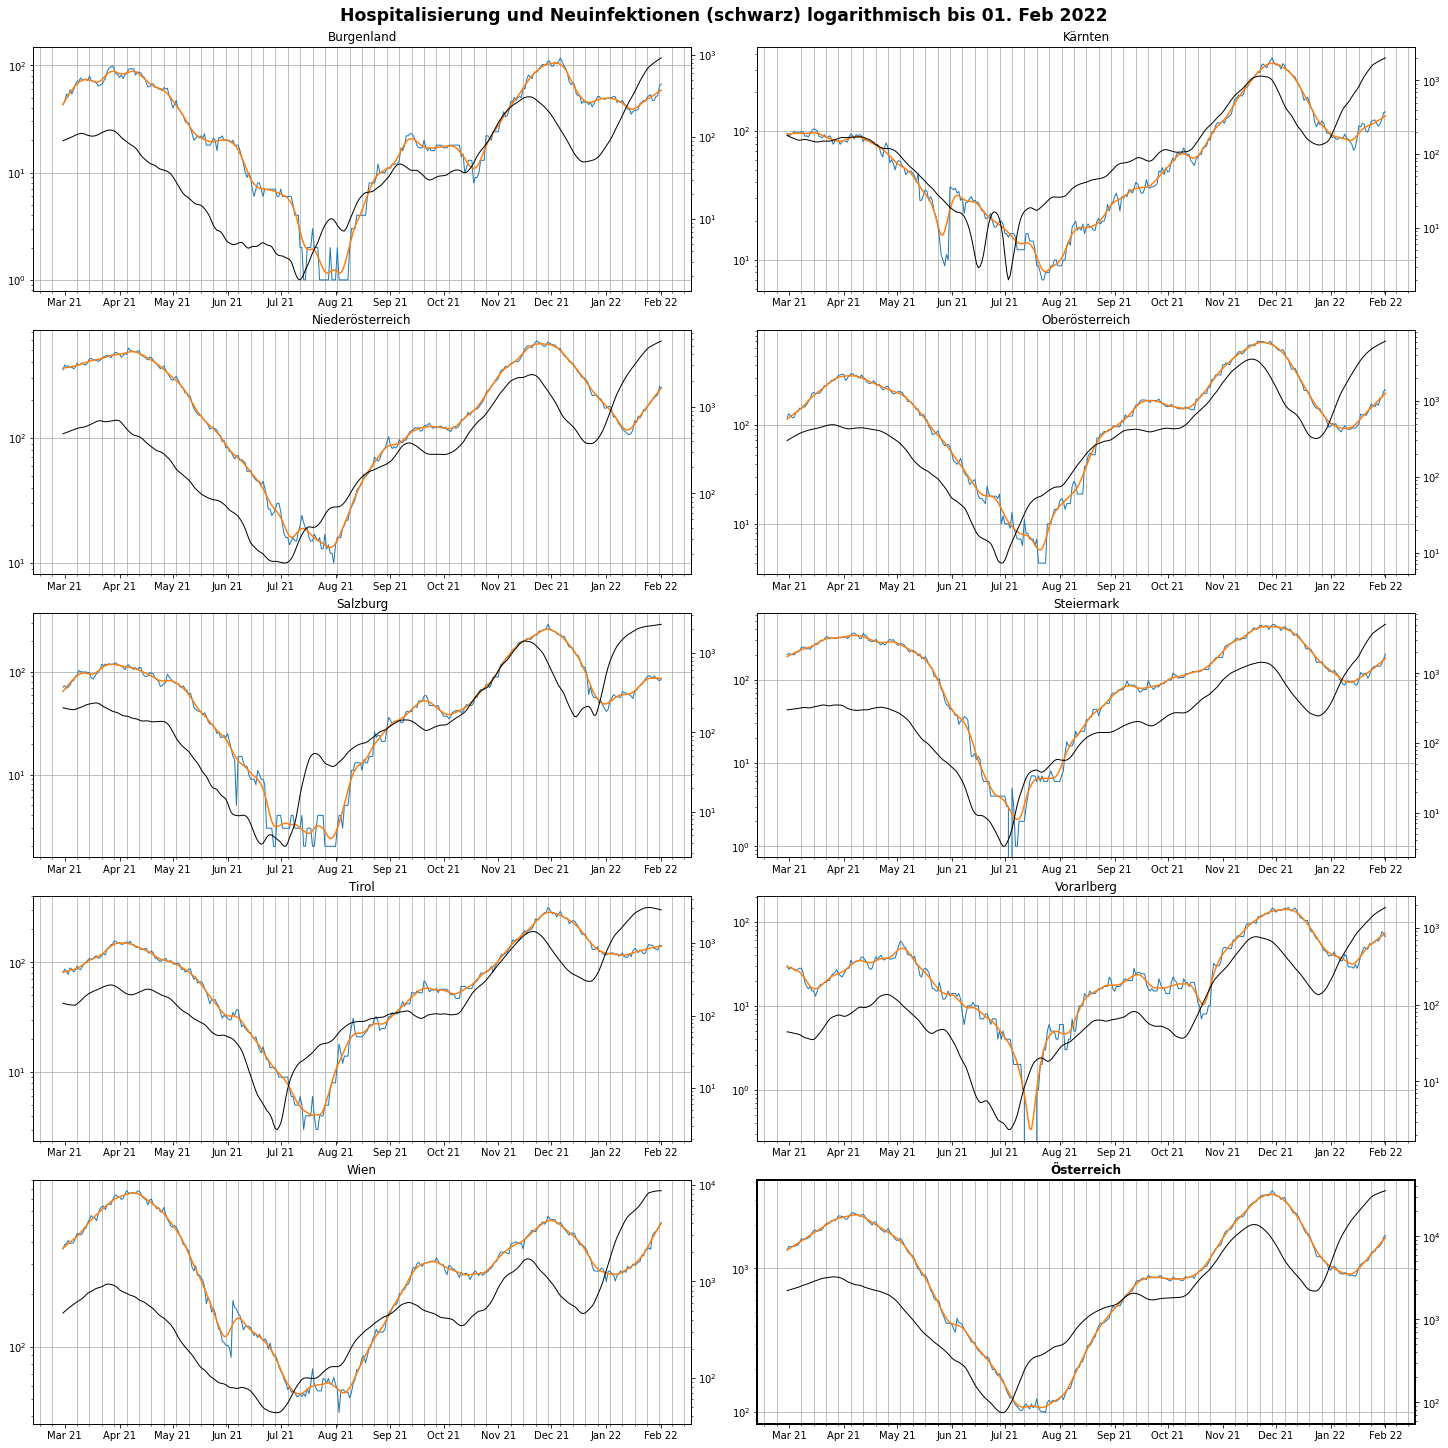

In [10]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [11]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCR": data.tail(7*10)["TestungenPCR"],
        "Diff": data.tail(8*10)["TestungenPCR"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCR:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-26,7 810 (1 936),9 683 (-7 129),368 004 (331 198),44 653 (-16 883),23 488 (587),35 071 (-9 861),30 360 (2 183),10 302 (-956),334 594 (-93 505),863 965 (207 570)
2022-01-27,17 041 (9 231),8 447 (-1 236),27 880 (-340 124),47 425 (2 772),18 543 (-4 945),46 473 (11 402),26 131 (-4 229),11 334 (1 032),403 515 (68 921),606 789 (-257 176)
2022-01-28,13 260 (-3 781),5 691 (-2 756),52 959 (25 079),45 581 (-1 844),19 339 (796),29 370 (-17 103),26 028 (-103),10 479 (-855),291 074 (-112 441),493 781 (-113 008)
2022-01-29,13 413 (153),8 298 (2 607),28 948 (-24 011),40 550 (-5 031),18 603 (-736),27 712 (-1 658),19 893 (-6 135),9 284 (-1 195),223 146 (-67 928),389 847 (-103 934)
2022-01-30,6 910 (-6 503),11 637 (3 339),41 001 (12 053),48 241 (7 691),15 148 (-3 455),30 486 (2 774),18 931 (-962),9 766 (482),65 002 (-158 144),247 122 (-142 725)
2022-01-31,10 183 (3 273),5 142 (-6 495),43 682 (2 681),36 296 (-11 945),14 669 (-479),23 673 (-6 813),33 281 (14 350),8 073 (-1 693),450 224 (385 222),625 223 (378 101)
2022-02-01,9 080 (-1 103),7 208 (2 066),282 132 (238 450),57 664 (21 368),22 000 (7 331),23 684 (11),20 866 (-12 415),13 760 (5 687),428 019 (-22 205),864 413 (239 190)


### Diagramm

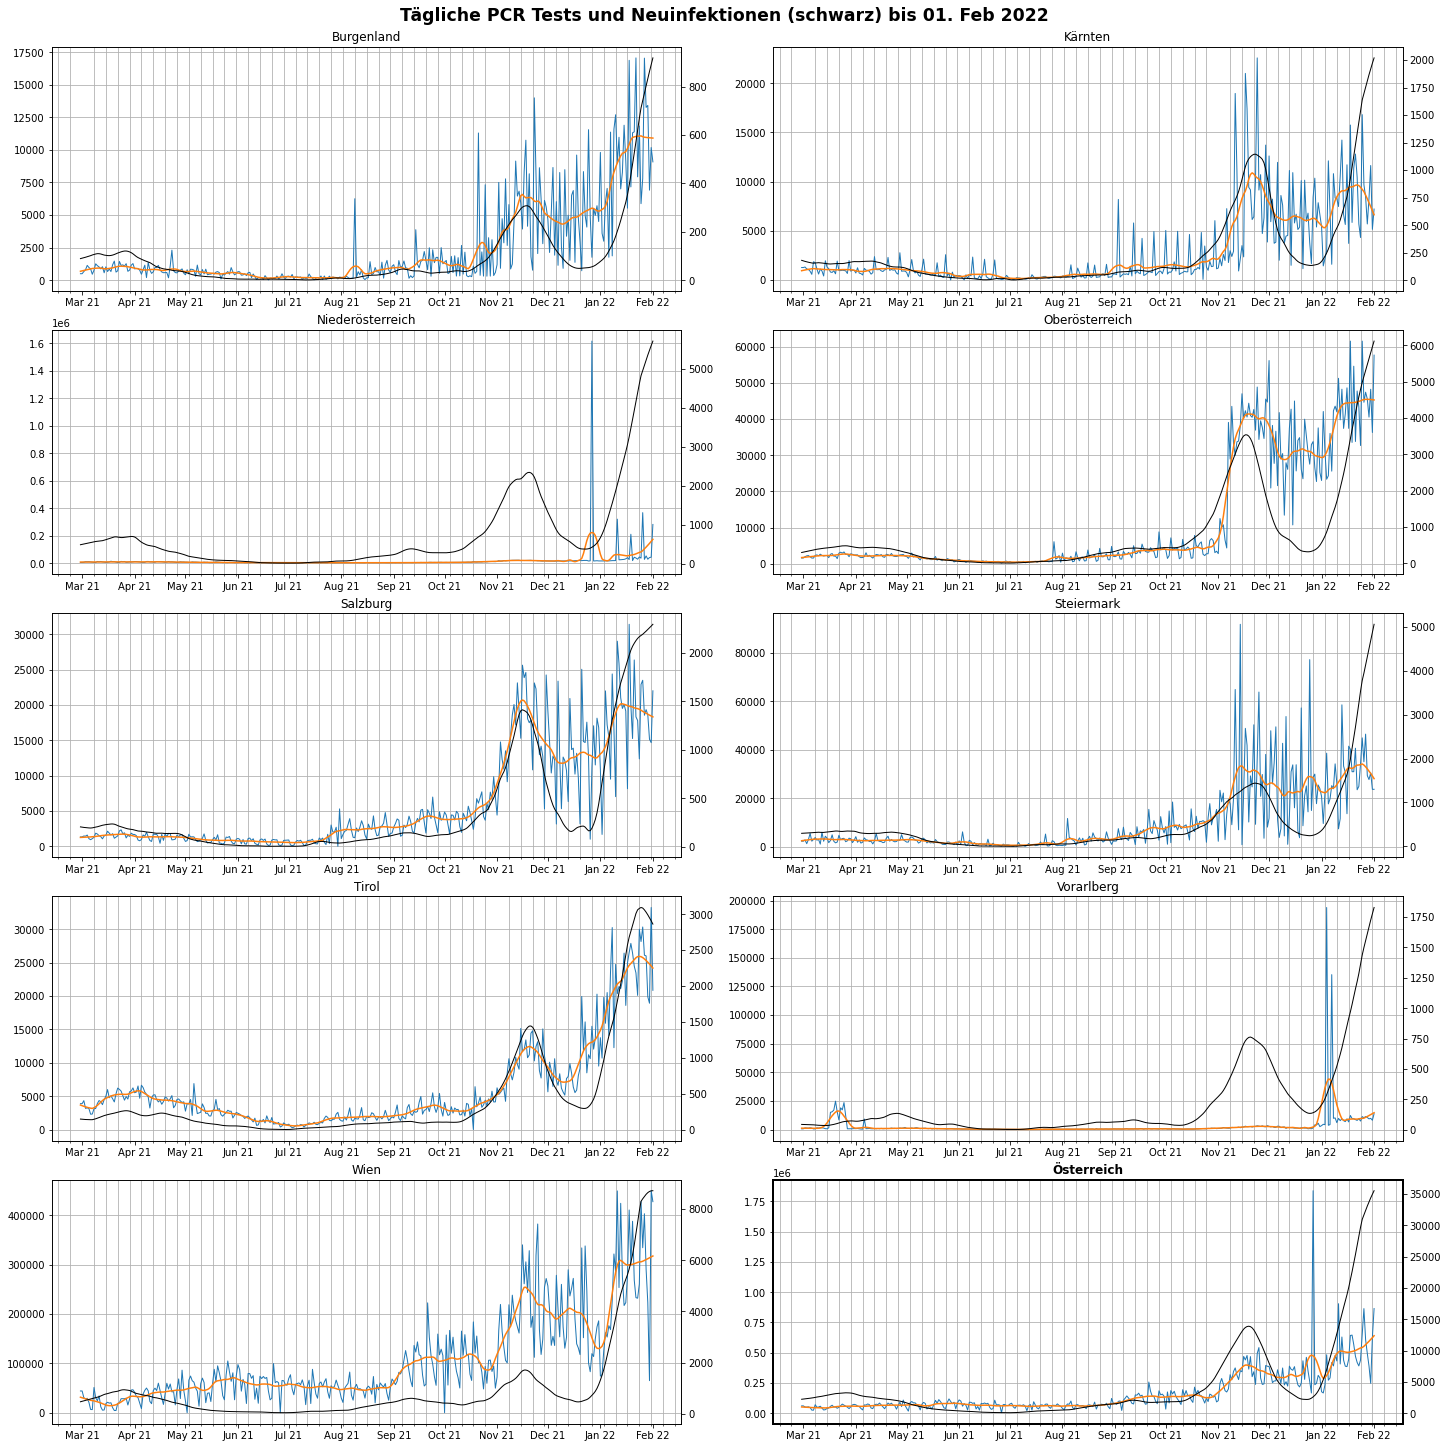

In [12]:
plot_param(["TestungenPCR", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)